In [2]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB

In [3]:
path = 'sentiment labelled sentences/'

In [4]:
def get_wordcounts(text, vectorizer=None):
    """
    Takes a string or list of strings and returns term frequencies for each word in
    a vectorizer's vocabulary. If no vectorizer is passed, the vocabulary will be generated
    from the input text's unigrams and bigrams.
    """
    if vectorizer is None:
        vectorizer = CountVectorizer(stop_words='english', min_df = 2, lowercase=True, ngram_range=(1,2))
        vectorizer.fit(text)
    term_counts = zip(vectorizer.get_feature_names(),
        np.asarray(vectorizer.transform(text).sum(axis=0)).ravel())
    return sorted(term_counts, key=lambda x: x[1], reverse=True)

def get_tfidf_weights(text, vectorizer=None):
    if vectorizer is None:
        vectorizer = TfidfVectorizer(stop_words='english', min_df = 2, lowercase=True, ngram_range=(1,2))
        vectorizer.fit(text)
    tfidf_weights = zip(vectorizer.get_feature_names(),
        np.asarray(vectorizer.transform(text).sum(axis=0)).ravel())
    return sorted(tfidf_weights, key=lambda x: x[1], reverse=True)

In [8]:
def get_tfidf(text):
    tfidf_vec = TfidfVectorizer(stop_words='english', min_df = 2, lowercase=True, ngram_range=(1,2))
    tfidf_vec.fit(text)

    train_tfidf = get_tfidf_weights(text, tfidf_vec)[:40]
    return train_tfidf

In [11]:
def get_counts(text):
    count_vec = CountVectorizer(stop_words='english', min_df = 2, lowercase=True, ngram_range=(1,2))
    
    count_vec.fit(text)
    train_counts = get_wordcounts(text, count_vec)[:40]
    return train_counts

In [5]:
amz_df = pd.read_csv(path+ 'amazon_cells_labelled.txt', delimiter= '\t')
amz_df.columns = ['text', 'target']

amz_df['target'] = pd.to_numeric(amz_df['target'])
amz_df = amz_df.dropna()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(amz_df.text, amz_df.target, test_size=0.25, random_state=42)

In [105]:
def get_pos_words(X_train, y_train, lst, train_pos):
    amz_df_train = pd.DataFrame({'text': X_train, 'target':y_train})

    # seperating positive messages from negative messages
    amz_df_pos = amz_df_train[(amz_df_train.target == 1)]
    amz_df_neg = amz_df_train[(amz_df_train.target == 0)]
    
    neg_words = []
    pos_words = []
    
    # compiling set of positive words
    if lst[0]== 1: 
        pos_words = [word_score[0] for word_score in get_tfidf(amz_df_pos.text)]
    if lst[1]== 1:
        pos_words = pos_words+ [word_score[0] for word_score in get_tfidf(amz_df_pos.text)]
    pos_words = list(set(pos_words))
    
    # compiling set of negative words
    if lst[2]== 1:
        neg_words = [word_score[0] for word_score in get_tfidf(amz_df_neg.text)]
    if lst[3] == 1:
        neg_words = neg_words + [word_score[0] for word_score in get_counts(amz_df_neg.text)]
    neg_words = list(set(neg_words))
    
    # weeding out overlapping words
    if train_pos == True:
        pos_words = [word for word in pos_words if word not in neg_words] 
    else:
        pos_words = [word for word in neg_words if word not in pos_words] 
        
    try:
        pos_words.remove('cell')
    except:
        pass
    
    return amz_df_train, pos_words

In [16]:
# creating a dictionary of vectors, one vector per word with rows corresponding to messages
def produce_word_df(pos_words, data):
    d = {word:[] for word in pos_words}
    for word in d.keys():
        d[word]= [1 if word in comment.lower() else 0 for comment in data]

    return pd.DataFrame(d)

In [87]:

def run_model(pos_words, df_train, df_test, y_test, X_test):
    bnb = BernoulliNB()
    bnb.fit(df_train[pos_words], df_train.target)

    y_pred = bnb.predict(df_test)

    print("Number of mislabeled points out of a total {} points : {}; {}% success improvement over {}% blind".format(
        len(y_test),
        (y_test != y_pred).sum(),
        round(((y_test == y_pred).sum()/len(y_test))*100,4),
        round((sum(y_test)/len(y_test))*100,4)
    ))

In [7]:
amz_df_train = pd.DataFrame({'text': X_train, 'target':y_train})

amz_df_pos = amz_df_train[(amz_df_train.target == 1)]
amz_df_neg = amz_df_train[(amz_df_train.target == 0)]

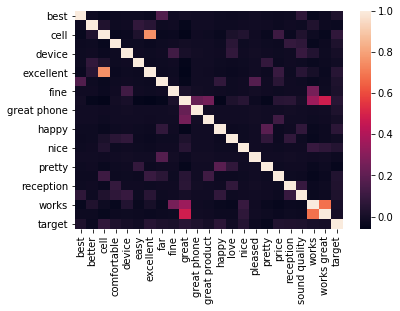

In [63]:
amz_df_train, pos_words = get_pos_words(X_train, y_train)

# prepping the test set 
df_test = produce_word_df(pos_words, X_test)
df_train = produce_word_df(pos_words, amz_df_train.text)
df_train['target'] = amz_df_train.target
df_train = df_train.dropna()
sns.heatmap(df_train.corr())

In [64]:
run_model(pos_words, df_train, df_test, y_test, X_test)

Number of mislabeled points out of a total 250 points : 93; 62.8% success improvement over 54.400000000000006% blind


In [88]:
# Investigating overfitting

## Case 1: training the model on all of the data and then measuring accuracy
amz_df_train, pos_words = get_pos_words(amz_df.text, amz_df.target, [1,1,1,1], train_pos=True)

df_train = produce_word_df(pos_words, amz_df_train.text)
df_train['target'] = amz_df_train.target

run_model(pos_words, df_train, df_train[pos_words], df_train.target, amz_df.text)

## Case 2: creating a list of positive words based on all data but training on a fraction and testing on remaining
amz_df_train, pos_words = get_pos_words(amz_df.text, amz_df.target, [1,1,1,1], train_pos=True)
amz_df_train, pos_words2 = get_pos_words(X_train, y_train, [1,1,1,1], train_pos=True)

# prepping the test set 
df_test = produce_word_df(pos_words, X_test)
df_train = produce_word_df(pos_words, amz_df_train.text)
df_train['target'] = amz_df_train.target
df_train = df_train.dropna()

run_model(pos_words, df_train, df_test, y_test, X_test)

Number of mislabeled points out of a total 999 points : 255; 74.4745% success improvement over 50.0501% blind
Number of mislabeled points out of a total 250 points : 87; 65.2% success improvement over 54.4% blind


Not surprisingly, the model performs best when it has been exposed to the largest set of possible words.  Of course it works particularly well when it has seen all the words that could come up in the test set, which is unrealistic because at some point the model has to run on unknown data.

In [96]:
# train the model with different versions of positive words
for ik in [[1,0,0,0],[0,1,0,0],[1,1,1,0],[1,1,0,1],[1,0,1,0],[1,0,0,1],[0,1,1,0],[0,1,0,1],[1,1,1,1]]:
    amz_df_train, pos_words = get_pos_words(X_train, y_train, ik, train_pos=True)

    # prepping the test set 
    df_test = produce_word_df(pos_words, X_test)
    df_train = produce_word_df(pos_words, amz_df_train.text)
    df_train['target'] = amz_df_train.target
    df_train = df_train.dropna()
    
    print(ik)
    run_model(pos_words, df_train, df_test, y_test, X_test)

[1, 0, 0, 0]
Number of mislabeled points out of a total 250 points : 88; 64.8% success improvement over 54.4% blind
[0, 1, 0, 0]
Number of mislabeled points out of a total 250 points : 88; 64.8% success improvement over 54.4% blind
[1, 1, 1, 0]
Number of mislabeled points out of a total 250 points : 86; 65.6% success improvement over 54.4% blind
[1, 1, 0, 1]
Number of mislabeled points out of a total 250 points : 96; 61.6% success improvement over 54.4% blind
[1, 0, 1, 0]
Number of mislabeled points out of a total 250 points : 86; 65.6% success improvement over 54.4% blind
[1, 0, 0, 1]
Number of mislabeled points out of a total 250 points : 96; 61.6% success improvement over 54.4% blind
[0, 1, 1, 0]
Number of mislabeled points out of a total 250 points : 86; 65.6% success improvement over 54.4% blind
[0, 1, 0, 1]
Number of mislabeled points out of a total 250 points : 96; 61.6% success improvement over 54.4% blind
[1, 1, 1, 1]
Number of mislabeled points out of a total 250 points : 99;

[1, 1, 1, 0],[1, 0, 1, 0],[0, 1, 1, 0], used to train for positive (rather than negative) words, were the top three.  The common thread seems to be removeal of the negative tfidf list.  

In [97]:
# train model for different versions of negative words
for ik in [[1,1,1,0],[1,1,0,1],[1,0,1,0],[1,0,0,1],[0,1,1,0],[0,1,0,1],[0,0,1,0],[0,0,0,1],[1,1,1,1]]:
    amz_df_train, pos_words = get_pos_words(X_train, y_train, ik, train_pos=False)

    # prepping the test set 
    df_test = produce_word_df(pos_words, X_test)
    df_train = produce_word_df(pos_words, amz_df_train.text)
    df_train['target'] = amz_df_train.target
    df_train = df_train.dropna()
    
    print(ik)
    run_model(pos_words, df_train, df_test, y_test, X_test)

[1, 1, 1, 0]
Number of mislabeled points out of a total 250 points : 145; 42.0% success improvement over 54.4% blind
[1, 1, 0, 1]
Number of mislabeled points out of a total 250 points : 133; 46.8% success improvement over 54.4% blind
[1, 0, 1, 0]
Number of mislabeled points out of a total 250 points : 145; 42.0% success improvement over 54.4% blind
[1, 0, 0, 1]
Number of mislabeled points out of a total 250 points : 133; 46.8% success improvement over 54.4% blind
[0, 1, 1, 0]
Number of mislabeled points out of a total 250 points : 145; 42.0% success improvement over 54.4% blind
[0, 1, 0, 1]
Number of mislabeled points out of a total 250 points : 133; 46.8% success improvement over 54.4% blind
[0, 0, 1, 0]
Number of mislabeled points out of a total 250 points : 114; 54.4% success improvement over 54.4% blind
[0, 0, 0, 1]
Number of mislabeled points out of a total 250 points : 126; 49.6% success improvement over 54.4% blind
[1, 1, 1, 1]
Number of mislabeled points out of a total 250 poin

[0, 0, 1, 0] (just using the negative tfidf list) was the best list for training with negative words, though it didn't clear the success rate of assigning positive to everything.  

In [111]:
# one by one removing a word to see if it affects the success rate of the model:
amz_df_train, pos_words = get_pos_words(X_train, y_train, [1, 0, 1, 0], train_pos=True)

print(len(pos_words))
for ik in range(len(pos_words)):
    word = pos_words.pop(0)

    df_test = produce_word_df(pos_words, X_test)
    df_train = produce_word_df(pos_words, amz_df_train.text)
    df_train['target'] = amz_df_train.target
    df_train = df_train.dropna()
    print(word)
    run_model(pos_words, df_train, df_test, y_test, X_test)
    
    pos_words.append(word)

23
price
Number of mislabeled points out of a total 250 points : 93; 62.8% success improvement over 54.4% blind
works
Number of mislabeled points out of a total 250 points : 104; 58.4% success improvement over 54.4% blind
great product
Number of mislabeled points out of a total 250 points : 79; 68.4% success improvement over 54.4% blind
best
Number of mislabeled points out of a total 250 points : 93; 62.8% success improvement over 54.4% blind
comfortable
Number of mislabeled points out of a total 250 points : 100; 60.0% success improvement over 54.4% blind
just
Number of mislabeled points out of a total 250 points : 85; 66.0% success improvement over 54.4% blind
device
Number of mislabeled points out of a total 250 points : 81; 67.6% success improvement over 54.4% blind
better
Number of mislabeled points out of a total 250 points : 78; 68.8% success improvement over 54.4% blind
excellent
Number of mislabeled points out of a total 250 points : 101; 59.6% success improvement over 54.4% b

In [113]:
# one by one removing a word to see if it affects the success rate of the model:
amz_df_train, pos_words = get_pos_words(X_train, y_train, [1, 0, 1, 0], train_pos=True)
pos_words.remove('great product')

df_test = produce_word_df(pos_words, X_test)
df_train = produce_word_df(pos_words, amz_df_train.text)
df_train['target'] = amz_df_train.target
df_train = df_train.dropna()
run_model(pos_words, df_train, df_test, y_test, X_test)
    

Number of mislabeled points out of a total 250 points : 80; 68.0% success improvement over 54.4% blind


In [114]:
# one by one removing a word to see if it affects the success rate of the model:
amz_df_train, pos_words = get_pos_words(X_train, y_train, [1, 0, 1, 0], train_pos=True)
pos_words.remove('better')

df_test = produce_word_df(pos_words, X_test)
df_train = produce_word_df(pos_words, amz_df_train.text)
df_train['target'] = amz_df_train.target
df_train = df_train.dropna()
run_model(pos_words, df_train, df_test, y_test, X_test)
    

Number of mislabeled points out of a total 250 points : 76; 69.6% success improvement over 54.4% blind


In [115]:
# one by one removing a word to see if it affects the success rate of the model:
amz_df_train, pos_words = get_pos_words(X_train, y_train, [1, 0, 1, 0], train_pos=True)
pos_words.remove('better')
pos_words.remove('great product')

df_test = produce_word_df(pos_words, X_test)
df_train = produce_word_df(pos_words, amz_df_train.text)
df_train['target'] = amz_df_train.target
df_train = df_train.dropna()
run_model(pos_words, df_train, df_test, y_test, X_test)
    

Number of mislabeled points out of a total 250 points : 79; 68.4% success improvement over 54.4% blind


Interestingly, by removing ["great product"] or  ["better" and "great product"] we could improve the model performance by ~4% assuming tfidf positive words with tfidf negative words removed.